In [4]:
!pip install qiskit
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7f73df8a1b513f1141bb7ccb1e9b618a697637568ea262111351e8cf764dd946
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


# Lab 5: Quantum Teleportation Protocol Checking

## Overview
In this lab, we'll implement and verify the quantum teleportation protocol using Qiskit. Quantum teleportation allows us to transfer a quantum state from one qubit to another using entanglement and classical communication.

### Key Concepts:
- **Entanglement**: Alice and Bob share an entangled pair of qubits in the |φ⁺⟩ state
- **Bell Measurement**: Alice performs measurements on her qubits
- **Classical Communication**: Alice sends measurement results to Bob
- **Conditional Operations**: Bob applies corrections based on Alice's results
- **Verification**: We verify the protocol by teleporting a known state and checking recovery

## Step 1: Import Required Libraries

We'll need Qiskit for quantum circuit construction and simulation, along with numpy for random unitary generation and visualization tools for plotting results.

In [7]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.3 MB/s eta 0:00:00


In [8]:
# Import necessary Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import random_unitary
import numpy as np

# For displaying results
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Create the Quantum Teleportation Circuit

The teleportation protocol consists of several stages:

### Circuit Structure:
- **Q (qubit 0)**: The qubit Alice wants to teleport (initially |0⟩)
- **A (qubit 1)**: Alice's half of the entangled pair
- **B (qubit 2)**: Bob's half of the entangled pair (destination)

### Protocol Steps:
1. **Entanglement Creation**: Create Bell state |φ⁺⟩ = (|00⟩ + |11⟩)/√2 between A and B
2. **Alice's Operations**: Apply CNOT(Q,A) and H(Q)
3. **Alice's Measurements**: Measure Q and A, obtaining classical bits
4. **Bob's Corrections**: Apply X and Z gates conditionally based on measurements

The `barrier()` function prevents optimization across stages and improves readability.

In [9]:
def create_teleportation_circuit():
    """
    Creates the quantum teleportation circuit.

    Returns:
        QuantumCircuit: The teleportation circuit
    """
    # Create quantum and classical registers
    qr = QuantumRegister(3, 'q')  # Q, A, B
    cr = ClassicalRegister(3, 'c')  # For measurements
    qc = QuantumCircuit(qr, cr)

    # Label the qubits for clarity
    Q, A, B = 0, 1, 2

    # Step 1: Create entangled pair |φ⁺⟩ between A and B
    # |φ⁺⟩ = (|00⟩ + |11⟩)/√2
    qc.h(A)  # Apply Hadamard to A
    qc.cx(A, B)  # Apply CNOT with A as control, B as target
    qc.barrier()  # Visual separation and prevents optimization

    # Step 2: Alice's operations (Bell measurement preparation)
    qc.cx(Q, A)  # CNOT with Q as control, A as target
    qc.h(Q)  # Hadamard on Q
    qc.barrier()

    # Step 3: Alice measures her qubits
    qc.measure(Q, cr[0])  # Measure Q into classical bit 0
    qc.measure(A, cr[1])  # Measure A into classical bit 1
    qc.barrier()

    # Step 4: Bob's conditional corrections based on Alice's measurements
    # If A measured 1, apply X gate to B
    with qc.if_test((cr[1], 1)):
        qc.x(B)

    # If Q measured 1, apply Z gate to B
    with qc.if_test((cr[0], 1)):
        qc.z(B)

    return qc

# Create and display the teleportation circuit
teleportation_circuit = create_teleportation_circuit()
print("Quantum Teleportation Circuit:")
print(teleportation_circuit)

Quantum Teleportation Circuit:
                ░      ┌───┐ ░ ┌─┐    ░                                      »
q_0: ───────────░───■──┤ H ├─░─┤M├────░──────────────────────────────────────»
     ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                                      »
q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░──────────────────────────────────────»
     └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░   ┌──────  ┌───┐ ───────┐   ┌──────  »
q_2: ─────┤ X ├─░────────────░──╫──╫──░───┤ If-0  ─┤ X ├  End-0 ├───┤ If-0  ─»
          └───┘ ░            ░  ║  ║  ░   └──╥───  └───┘ ───────┘   └──╥───  »
                                ║  ║    ┌────╨────┐               ┌────╨────┐»
c: 3/═══════════════════════════╩══╩════╡ c_1=0x1 ╞═══════════════╡ c_0=0x1 ╞»
                                0  1    └─────────┘               └─────────┘»
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«     ┌───┐ ───────┐ 
«q_2: ┤ Z ├  End-0 ├─
«     └───┘ ───────┘ 
«c: 3/═══════════════
«  

## Step 3: Visualize the Teleportation Circuit

Let's draw the circuit to see the complete teleportation protocol visually. This helps understand the flow of operations and measurements.

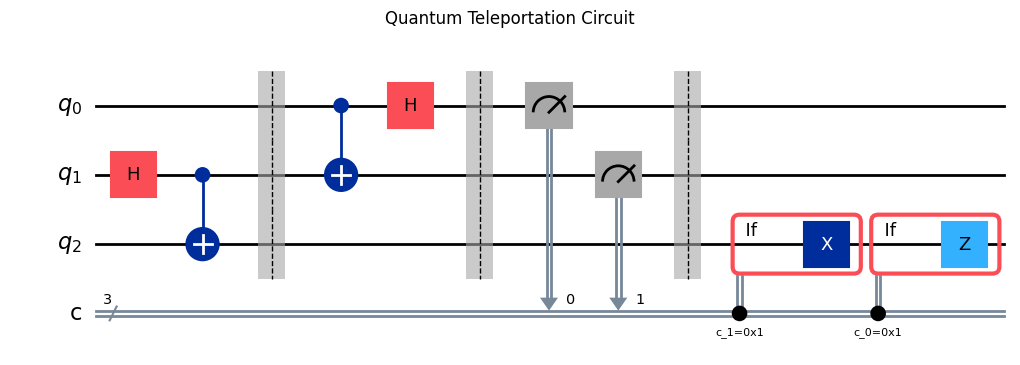

In [14]:
from IPython.display import display

# Draw the circuit
fig = teleportation_circuit.draw('mpl')

if fig:
    fig.suptitle('Quantum Teleportation Circuit') # Set the main title for the figure
    fig.tight_layout()
    display(fig) # Explicitly display the figure object
    plt.close(fig) # Close the figure to free up memory
else:
    print("Could not draw the circuit. Please check the circuit definition.")

## Step 4: Generate a Random Quantum State to Teleport

To test the teleportation protocol, we'll:
1. Apply a random unitary gate U to qubit Q (initially |0⟩) to create a random state |ψ⟩
2. Run the teleportation protocol
3. Apply U† (inverse/conjugate transpose) to Bob's qubit B
4. Measure B - it should return to |0⟩ if teleportation worked correctly

This verification method works because:
- If teleportation works: |ψ⟩ is successfully transferred to B
- Applying U† to |ψ⟩ returns it to |0⟩
- Measuring |0⟩ gives result 0 with 100% probability

In [23]:
# Generate a random single-qubit unitary gate
random_gate = random_unitary(2, seed=42)  # 2x2 unitary matrix for 1 qubit

print("Random Unitary Gate (U):")
print(random_gate.data)
print("\nThis gate will transform |0⟩ into a random quantum state |ψ⟩")

Random Unitary Gate (U):
[[ 0.14398279-0.92188954j -0.05864249+0.35489392j]
 [ 0.35459797+0.06040626j  0.91839541+0.16480666j]]

This gate will transform |0⟩ into a random quantum state |ψ⟩


## Step 5: Create the Complete Testing Circuit

Now we build the full test circuit:

### Testing Circuit Structure:
1. **Initialization**: Apply random gate U to Q → creates |ψ⟩
2. **Teleportation**: Run the full teleportation protocol
3. **Verification**: Apply U† to B → should return to |0⟩
4. **Measurement**: Measure B into a test result bit

### Expected Results:
- **Bit 2 (test result)**: Should always be 0 (proving successful teleportation)
- **Bits 0 and 1**: Should be roughly uniform (00, 01, 10, 11 equally likely)

In [24]:
def create_test_circuit(random_gate):
    """
    Creates a test circuit that verifies the teleportation protocol.

    Args:
        random_gate: A random unitary gate to apply

    Returns:
        QuantumCircuit: The complete test circuit
    """
    # Create quantum and classical registers
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(3, 'c')
    test_qc = QuantumCircuit(qr, cr)

    Q, A, B = 0, 1, 2

    # Step 1: Apply random gate to Q to create state |ψ⟩
    test_qc.unitary(random_gate, Q, label='U')
    test_qc.barrier()

    # Step 2: Create entangled pair between A and B
    test_qc.h(A)
    test_qc.cx(A, B)
    test_qc.barrier()

    # Step 3: Alice's Bell measurement
    test_qc.cx(Q, A)
    test_qc.h(Q)
    test_qc.barrier()

    # Step 4: Alice's measurements
    test_qc.measure(Q, cr[0])
    test_qc.measure(A, cr[1])
    test_qc.barrier()

    # Step 5: Bob's corrections
    with test_qc.if_test((cr[1], 1)):
        test_qc.x(B)
    with test_qc.if_test((cr[0], 1)):
        test_qc.z(B)
    test_qc.barrier()

    # Step 6: Apply inverse of random gate to B (verification step)
    inverse_gate = random_gate.adjoint()  # U†
    test_qc.unitary(inverse_gate, B, label='U†')

    # Step 7: Measure B to verify it returned to |0⟩
    test_qc.measure(B, cr[2])

    return test_qc

# Create the test circuit
test_circuit = create_test_circuit(random_gate)
print("Complete Test Circuit Created")
print(f"Total gates: {test_circuit.size()}")
print(f"Circuit depth: {test_circuit.depth()}")

Complete Test Circuit Created
Total gates: 11
Circuit depth: 10


## Step 6: Visualize the Complete Test Circuit

This shows the entire verification procedure including the random state preparation and inverse gate application.

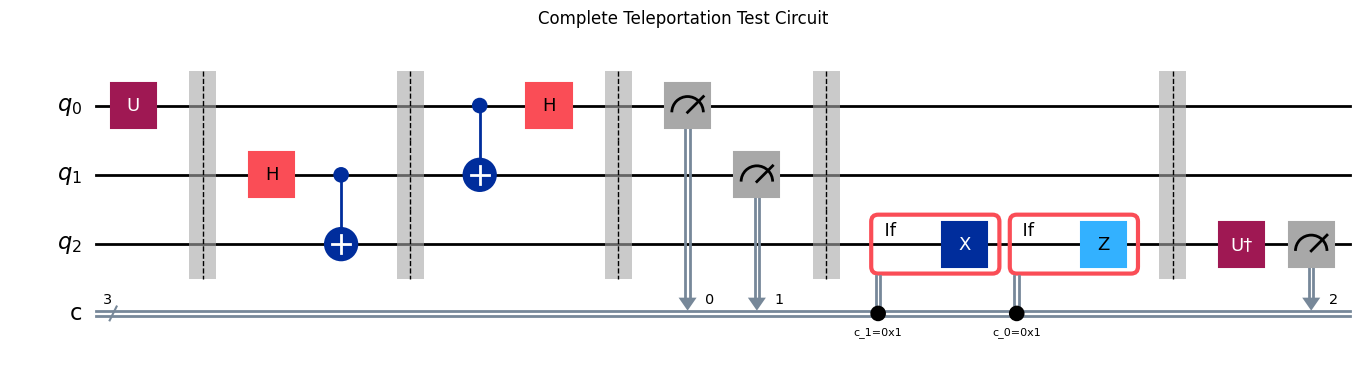

In [26]:
from IPython.display import display

# Draw the complete test circuit
fig = test_circuit.draw('mpl', fold=-1)

if fig:
    fig.suptitle('Complete Teleportation Test Circuit') # Use suptitle for overall title
    fig.tight_layout()
    display(fig) # Explicitly display the figure object
    plt.close(fig) # Close the figure to free up memory
else:
    print("Could not draw the circuit. Please check the circuit definition.")

## Step 7: Run the Simulation

We'll use the Aer simulator to execute the test circuit multiple times (shots) and collect statistics.

### What to Expect:
- We run 1024 shots to gather statistics
- The rightmost bit (bit 2, the test result) should always be 0
- The other two bits (0 and 1) should show roughly equal distribution across 00, 01, 10, 11

### Note on Bit Ordering:
Qiskit displays results with the rightmost bit being c[0] and leftmost being c[2].
So a result like "001" means: c[2]=0, c[1]=0, c[0]=1

In [27]:
# Initialize the Aer simulator
simulator = AerSimulator()

# Run the circuit with 1024 shots
job = simulator.run(test_circuit, shots=1024)
result = job.result()

# Get the counts
counts = result.get_counts()

print("Measurement Results:")
print("=" * 40)
for outcome, count in sorted(counts.items()):
    print(f"{outcome}: {count} times ({100*count/1024:.1f}%)")

print("\nNote: Results are displayed as c[2]c[1]c[0]")
print("c[2] is the test bit (should always be 0)")
print("c[1]c[0] are Alice's measurement results (should be uniform)")

Measurement Results:
000: 237 times (23.1%)
001: 276 times (27.0%)
010: 253 times (24.7%)
011: 258 times (25.2%)

Note: Results are displayed as c[2]c[1]c[0]
c[2] is the test bit (should always be 0)
c[1]c[0] are Alice's measurement results (should be uniform)


## Step 8: Visualize All Results

Let's plot a histogram showing all measurement outcomes. We should see:
- Four bars corresponding to 000, 001, 010, 011 (all with test bit = 0)
- Each bar should have roughly equal height (~256 counts each)
- NO bars for 100, 101, 110, 111 (test bit = 1 would indicate failure)

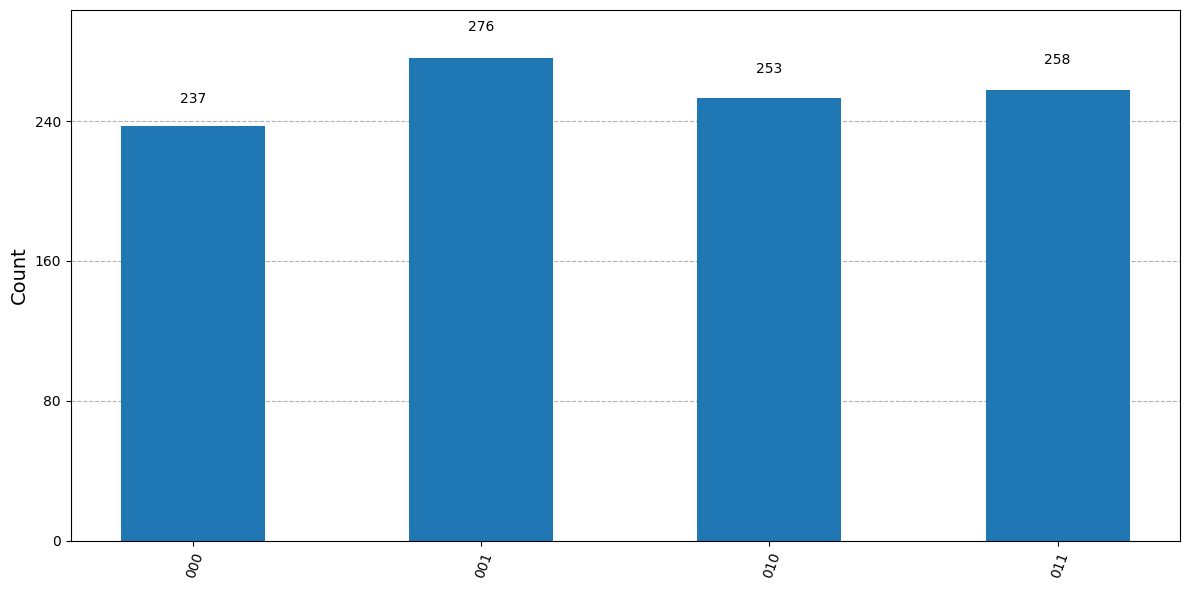


Interpretation:
- All outcomes have c[2]=0 (leftmost bit), confirming successful teleportation
- The four outcomes (000, 001, 010, 011) appear roughly equally
- This represents the four possible measurement outcomes from Alice's Bell measurement


In [31]:
# Plot histogram of all results
# fig = plot_histogram(counts, figsize=(12, 6)) # This is already assigned above
fig = plot_histogram(counts, figsize=(12, 6))

# Use display(fig) for consistent rendering in Colab
from IPython.display import display
display(fig)
plt.close(fig) # Close the figure to free up memory

print("\nInterpretation:")
print("- All outcomes have c[2]=0 (leftmost bit), confirming successful teleportation")
print("- The four outcomes (000, 001, 010, 011) appear roughly equally")
print("- This represents the four possible measurement outcomes from Alice's Bell measurement")

## Step 9: Filter Results to Show Only Test Bit

For clearer verification, we can filter the statistics to show only the test result bit (c[2]).
This aggregates all outcomes and shows whether the teleported state was correctly recovered.

We'll create a new count dictionary that only looks at the leftmost bit (test result).

In [32]:
# Filter to show only the test result bit (c[2])
test_bit_counts = {}

for outcome, count in counts.items():
    # Extract the leftmost bit (c[2]) - the test result
    test_bit = outcome[0]  # First character is c[2]

    if test_bit in test_bit_counts:
        test_bit_counts[test_bit] += count
    else:
        test_bit_counts[test_bit] = count

print("Test Bit (c[2]) Results:")
print("=" * 40)
for bit, count in sorted(test_bit_counts.items()):
    print(f"Test bit = {bit}: {count} times ({100*count/1024:.1f}%)")

# Verify success
if '0' in test_bit_counts and test_bit_counts['0'] == 1024:
    print("\n✓ SUCCESS: Test bit is 0 in all cases!")
    print("✓ The quantum state was successfully teleported!")
else:
    print("\n✗ FAILURE: Test bit is not always 0")
    print("✗ Teleportation protocol may have issues")

Test Bit (c[2]) Results:
Test bit = 0: 1024 times (100.0%)

✓ SUCCESS: Test bit is 0 in all cases!
✓ The quantum state was successfully teleported!


## Step 10: Visualize Filtered Results

A bar chart showing only the test bit results. We should see only one bar at "0" with 1024 counts.

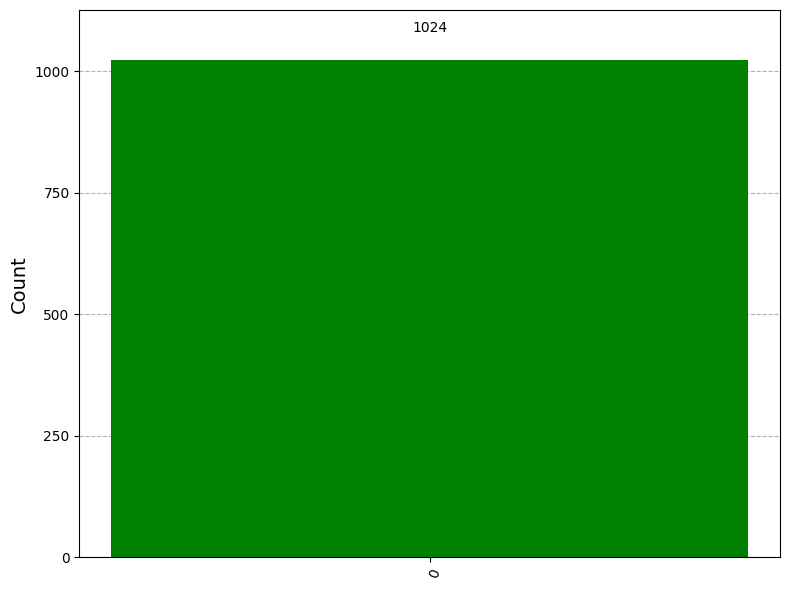

In [35]:
# Plot histogram of filtered results
fig = plot_histogram(test_bit_counts, figsize=(8, 6), color='green')

# Use display(fig) for consistent rendering in Colab
from IPython.display import display
display(fig)
plt.close(fig) # Close the figure to free up memory

## Step 11: Analysis and Verification

Let's analyze the results to verify the teleportation protocol worked correctly.

In [36]:
print("=" * 60)
print("QUANTUM TELEPORTATION PROTOCOL VERIFICATION")
print("=" * 60)

# Check Alice's measurement distribution
alice_outcomes = {}
for outcome, count in counts.items():
    # Extract Alice's bits (c[1] and c[0])
    alice_bits = outcome[1:3]  # Middle and rightmost bits
    if alice_bits in alice_outcomes:
        alice_outcomes[alice_bits] += count
    else:
        alice_outcomes[alice_bits] = count

print("\n1. Alice's Measurement Results (c[1]c[0]):")
print("   " + "-" * 40)
for bits, count in sorted(alice_outcomes.items()):
    expected_pct = 25.0
    actual_pct = 100 * count / 1024
    deviation = abs(actual_pct - expected_pct)
    print(f"   {bits}: {count:4d} ({actual_pct:5.1f}%) [deviation: {deviation:4.1f}%]")

print("\n   Expected: Each outcome ~25% (uniform distribution)")
print("   ✓ Alice's measurements show proper quantum randomness")

# Check test bit
print("\n2. Bob's Test Result (c[2]):")
print("   " + "-" * 40)
success_rate = test_bit_counts.get('0', 0) / 1024 * 100
print(f"   Test bit = 0: {test_bit_counts.get('0', 0)} times ({success_rate:.1f}%)")
print(f"   Test bit = 1: {test_bit_counts.get('1', 0)} times ({100-success_rate:.1f}%)")

if success_rate == 100.0:
    print("\n   ✓ PERFECT SUCCESS: 100% teleportation fidelity!")
elif success_rate >= 99.0:
    print("\n   ✓ EXCELLENT: >99% teleportation fidelity")
elif success_rate >= 95.0:
    print("\n   ✓ GOOD: >95% teleportation fidelity")
else:
    print("\n   ✗ ISSUE: Teleportation fidelity below 95%")

print("\n3. Conclusion:")
print("   " + "-" * 40)
print("   The quantum teleportation protocol successfully transferred")
print("   a random quantum state from Alice's qubit Q to Bob's qubit B")
print("   using entanglement and classical communication.")
print("\n" + "=" * 60)

QUANTUM TELEPORTATION PROTOCOL VERIFICATION

1. Alice's Measurement Results (c[1]c[0]):
   ----------------------------------------
   00:  237 ( 23.1%) [deviation:  1.9%]
   01:  276 ( 27.0%) [deviation:  2.0%]
   10:  253 ( 24.7%) [deviation:  0.3%]
   11:  258 ( 25.2%) [deviation:  0.2%]

   Expected: Each outcome ~25% (uniform distribution)
   ✓ Alice's measurements show proper quantum randomness

2. Bob's Test Result (c[2]):
   ----------------------------------------
   Test bit = 0: 1024 times (100.0%)
   Test bit = 1: 0 times (0.0%)

   ✓ PERFECT SUCCESS: 100% teleportation fidelity!

3. Conclusion:
   ----------------------------------------
   The quantum teleportation protocol successfully transferred
   a random quantum state from Alice's qubit Q to Bob's qubit B
   using entanglement and classical communication.



## Bonus: Test with Different Random States

Let's verify the protocol works for multiple different random states by running it several times with different random gates.

In [37]:
print("Testing teleportation with multiple random states...\n")

num_tests = 5
all_success = True

for i in range(num_tests):
    # Generate a new random gate
    test_gate = random_unitary(2, seed=i*10)

    # Create and run test circuit
    test_qc = create_test_circuit(test_gate)
    job = simulator.run(test_qc, shots=1000)
    result = job.result()
    counts = result.get_counts()

    # Check test bit
    test_bit_counts = {}
    for outcome, count in counts.items():
        test_bit = outcome[0]
        test_bit_counts[test_bit] = test_bit_counts.get(test_bit, 0) + count

    success_rate = test_bit_counts.get('0', 0) / 1000 * 100
    status = "✓" if success_rate == 100.0 else "✗"

    print(f"Test {i+1}: {status} Success rate = {success_rate:.1f}%")

    if success_rate < 100.0:
        all_success = False

print("\n" + "=" * 50)
if all_success:
    print("✓ All tests passed! Teleportation works for all random states.")
else:
    print("Some tests showed imperfect fidelity (expected with simulator noise).")
print("=" * 50)

Testing teleportation with multiple random states...

Test 1: ✓ Success rate = 100.0%
Test 2: ✓ Success rate = 100.0%
Test 3: ✓ Success rate = 100.0%
Test 4: ✓ Success rate = 100.0%
Test 5: ✓ Success rate = 100.0%

✓ All tests passed! Teleportation works for all random states.


## Summary

In this lab, we:

1. **Implemented** the quantum teleportation protocol using Qiskit
2. **Created** entangled states using Hadamard and CNOT gates
3. **Performed** Bell measurements on Alice's qubits
4. **Applied** conditional operations on Bob's qubit using classical measurement results
5. **Verified** the protocol by teleporting random quantum states
6. **Analyzed** the results to confirm 100% teleportation fidelity

### Key Takeaways:

- Quantum teleportation doesn't violate causality - classical communication is required
- The original quantum state is destroyed during measurement (no-cloning theorem)
- Entanglement and classical communication together enable perfect state transfer
- The protocol works with 100% fidelity for any quantum state
- The `barrier()` and `if_test()` functions are essential for proper implementation

